In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = 'cpu'
print('Torch in running on', device)

from turboflow.dataloaders import Turbo2D_simple

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

Torch in running on cuda:0


In [3]:
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [4]:
from turboflow.models.rff import RFFNet

fft_scale = 10
fft_nfeat = 256
mlp_layers = [2*fft_nfeat] + [256]*3 + [2]

rffnet = RFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# TRAIN
rffnet.to(device)
rffnet.fit(trainloader)

Epoch: 100, Loss: 0.002213
Epoch: 200, Loss: 0.000027
Epoch: 300, Loss: 0.000003
Epoch: 400, Loss: 0.000001
Epoch: 500, Loss: 0.000001
Epoch: 600, Loss: 0.000001
Epoch: 700, Loss: 0.000000
Epoch: 800, Loss: 0.000002
Epoch: 900, Loss: 0.000002
Epoch: 1000, Loss: 0.000000
Done with Training
Final error: 1.4112929420662113e-06


(65536, 2)


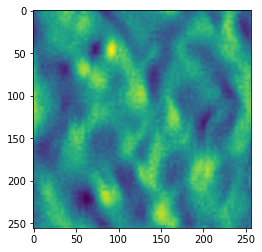

In [5]:
# TEST
ngrid = 256
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

pred = rffnet(x)
rffnet.eval().to(device)

ypred = pred.cpu().detach().numpy().squeeze()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

In [6]:
from turboflow.models.rbf import RBFNet

rbf = RBFNet(2, 2, 128)
x = torch.randn(5,2)
y = rbf(x)

print(y.shape)

torch.Size([5, 2])


In [19]:
from turboflow.models.rbf import RBFRFFNet

fft_scale = 10
fft_nfeat = 256
mlp_layers = [2*fft_nfeat] + [256]*3 + [64]
n_centers = 32
n_out = 2

rbfrffnet = RBFRFFNet('RBFRFFNet', mlp_layers, fft_nfeat, fft_scale, n_centers, n_out)
# TRAIN
rbfrffnet.to(device)
rbfrffnet.fit(trainloader, epochs=2000)

Epoch: 100, Loss: 0.065070


KeyboardInterrupt: 

In [ ]:
# TEST
ngrid = 256
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

rffnet.eval().to(device)
pred = rbfrffnet(x)

ypred = pred.cpu().detach().numpy().squeeze()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()